In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Importing the ETH–USD historical data and previewing the first few rows to verify the structure before analysis.

In [2]:
et=pd.read_csv('/kaggle/input/neweth/eth-usd-max.csv')
et.head(5)



,snapped_at,price,market_cap,total_volume
0,2015-08-07 00:00:00 UTC,2.831620,0.000000e+00,9.062200e+04
1,2015-08-08 00:00:00 UTC,1.330750,8.033948e+07,3.680700e+05
2,2015-08-10 00:00:00 UTC,0.687586,4.155631e+07,4.004641e+05
3,2015-08-11 00:00:00 UTC,1.067379,6.453901e+07,1.518998e+06
4,2015-08-12 00:00:00 UTC,1.256613,7.601326e+07,2.073893e+06


### Dataset Structure Check
Inspecting column types, missing values, and overall dataset structure before preprocessing.


In [3]:
et.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   snapped_at    3707 non-null   object 
 1   price         3707 non-null   float64
 2   market_cap    3707 non-null   float64
 3   total_volume  3707 non-null   float64
dtypes: float64(3), object(1)
memory usage: 116.0+ KB


### Data Quality Check
Checking for null, NaN, and infinite values across key numerical columns to ensure the dataset is clean before feature engineering.


In [4]:
null=print(et.isnull().sum())
print('NULL values',null)
print('\n')
nan=print(et.isna().sum())
print('NAN VALUES',nan)
print('\n')
inif=np.isinf(et[['market_cap','total_volume']]).values.any()
print('infinite values are :',inif)

snapped_at      0
price           0
market_cap      0
total_volume    0
dtype: int64
NULL values None


snapped_at      0
price           0
market_cap      0
total_volume    0
dtype: int64
NAN VALUES None


infinite values are : False


### Converting Timestamp Column
Converting the `snapped_at` column to a proper datetime format to enable accurate time-series indexing and analysis.


In [5]:
et['snapped_at'] = pd.to_datetime(et['snapped_at'], utc=True)  
print(et['snapped_at'].head())

0   2015-08-07 00:00:00+00:00
1   2015-08-08 00:00:00+00:00
2   2015-08-10 00:00:00+00:00
3   2015-08-11 00:00:00+00:00
4   2015-08-12 00:00:00+00:00
Name: snapped_at, dtype: datetime64[ns, UTC]


### Converting UTC to IST
Creating a localized timestamp column by converting the original UTC time to IST (Asia/Kolkata) for region-specific analysis.


In [6]:
et['snapped_ist'] = et['snapped_at'].dt.tz_convert('Asia/Kolkata')
print(et['snapped_ist'].head())

0   2015-08-07 05:30:00+05:30
1   2015-08-08 05:30:00+05:30
2   2015-08-10 05:30:00+05:30
3   2015-08-11 05:30:00+05:30
4   2015-08-12 05:30:00+05:30
Name: snapped_ist, dtype: datetime64[ns, Asia/Kolkata]


### Extracting Date-Time Features
Deriving date, hour, weekday, and month from the localized timestamp to enable time-based feature engineering and trend analysis.


In [7]:
et['date']=et['snapped_ist'].dt.date
print(et['date'].head(5))
print('\n')
et['hour']=et['snapped_ist'].dt.hour
print(et['hour'].head(5))
print('\n')
et['weekday']=et['snapped_ist'].dt.day_name()
print(et['weekday'].head(5))
print('\n')
et['month']=et['snapped_ist'].dt.month
print(et['month'].head(5))

0    2015-08-07
1    2015-08-08
2    2015-08-10
3    2015-08-11
4    2015-08-12
Name: date, dtype: object


0    5
1    5
2    5
3    5
4    5
Name: hour, dtype: int32


0       Friday
1     Saturday
2       Monday
3      Tuesday
4    Wednesday
Name: weekday, dtype: object


0    8
1    8
2    8
3    8
4    8
Name: month, dtype: int32


### Setting Timestamp as Index
Setting the localized timestamp as the DataFrame index and sorting it to prepare the data for time-series analysis.


In [8]:
et = et.set_index('snapped_ist').sort_index()
print(et.head())

                                         snapped_at     price    market_cap  \
snapped_ist                                                                   
2015-08-07 05:30:00+05:30 2015-08-07 00:00:00+00:00  2.831620  0.000000e+00   
2015-08-08 05:30:00+05:30 2015-08-08 00:00:00+00:00  1.330750  8.033948e+07   
2015-08-10 05:30:00+05:30 2015-08-10 00:00:00+00:00  0.687586  4.155631e+07   
2015-08-11 05:30:00+05:30 2015-08-11 00:00:00+00:00  1.067379  6.453901e+07   
2015-08-12 05:30:00+05:30 2015-08-12 00:00:00+00:00  1.256613  7.601326e+07   

                           total_volume        date  hour    weekday  month  
snapped_ist                                                                  
2015-08-07 05:30:00+05:30  9.062200e+04  2015-08-07     5     Friday      8  
2015-08-08 05:30:00+05:30  3.680700e+05  2015-08-08     5   Saturday      8  
2015-08-10 05:30:00+05:30  4.004641e+05  2015-08-10     5     Monday      8  
2015-08-11 05:30:00+05:30  1.518998e+06  2015-08-11     

### Summary Statistics
Generating descriptive statistics to understand the distribution, scale, and variability of key numerical features before modeling.


In [9]:
et.describe()

,price,market_cap,total_volume,hour,month
count,3707.000000,3.707000e+03,3.707000e+03,3707.0,3707.000000
mean,1281.533378,1.512200e+11,1.168741e+10,5.0,6.551929
std,1298.305240,1.565159e+11,1.335089e+10,0.0,3.433304
min,0.432979,0.000000e+00,8.707480e+04,5.0,1.000000
25%,170.367379,1.817008e+10,1.137178e+09,5.0,4.000000
50%,665.225786,6.824521e+10,8.615288e+09,5.0,7.000000
75%,2265.999090,2.694729e+11,1.679695e+10,5.0,9.000000
max,4829.225542,5.828170e+11,1.409065e+11,5.0,12.000000


### Ethereum Market Dashboard
Visualizing key market indicators — price trends, market capitalization, trading volume, and value distributions — to understand historical behavior and detect structural patterns before building predictive models.


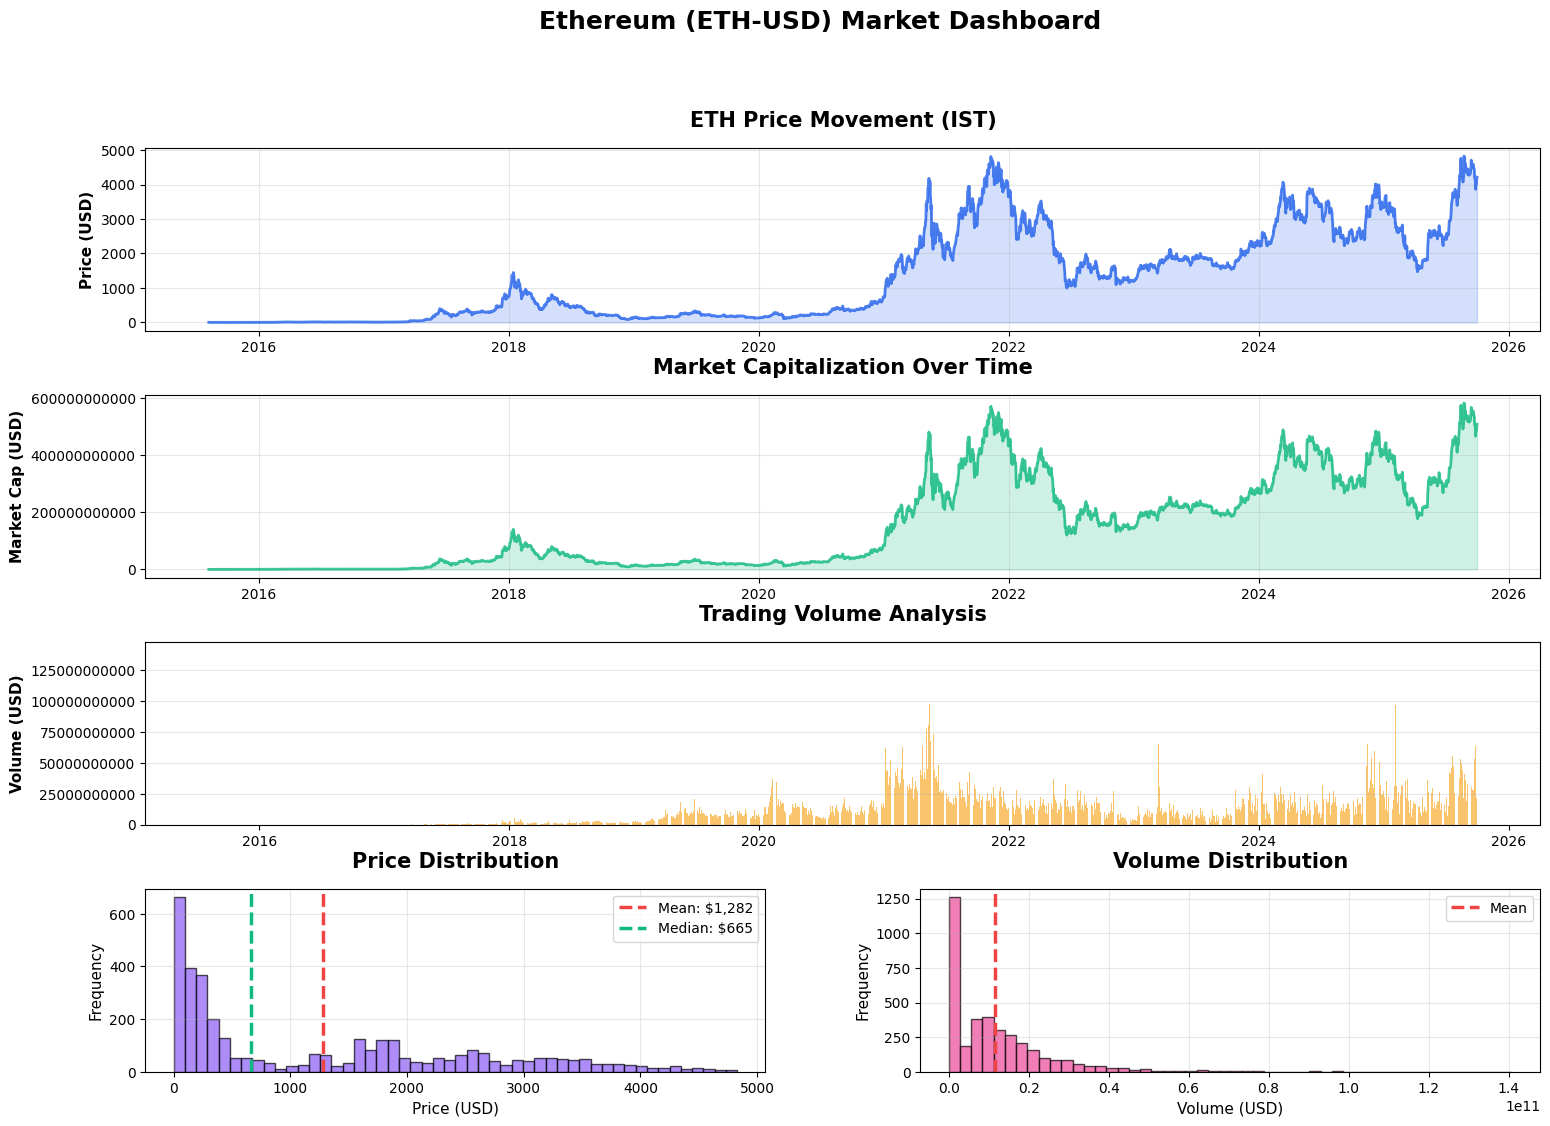

In [10]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.25)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(et.index, et['price'], linewidth=2, color='#2563eb', alpha=0.8)
ax1.fill_between(et.index, et['price'], alpha=0.2, color='#2563eb')
ax1.set_title('ETH Price Movement (IST)', fontsize=15, fontweight='bold', pad=15)
ax1.set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.ticklabel_format(style='plain', axis='y')



ax2 = fig.add_subplot(gs[1, :])
ax2.plot(et.index, et['market_cap'], linewidth=2, color='#10b981', alpha=0.8)
ax2.fill_between(et.index, et['market_cap'], alpha=0.2, color='#10b981')
ax2.set_title('Market Capitalization Over Time', fontsize=15, fontweight='bold', pad=15)
ax2.set_ylabel('Market Cap (USD)', fontsize=11, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.ticklabel_format(style='plain', axis='y')


ax3 = fig.add_subplot(gs[2, :])
ax3.bar(et.index, et['total_volume'], color='#f59e0b', alpha=0.6, width=0.8)
ax3.set_title('Trading Volume Analysis', fontsize=15, fontweight='bold', pad=15)
ax3.set_ylabel('Volume (USD)', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')
ax3.ticklabel_format(style='plain', axis='y')


ax4 = fig.add_subplot(gs[3, 0])
ax4.hist(et['price'], bins=50, color='#8b5cf6', edgecolor='black', alpha=0.7)
ax4.axvline(et['price'].mean(), color='#ef4444', linestyle='--', linewidth=2.5, label=f"Mean: ${et['price'].mean():,.0f}")
ax4.axvline(et['price'].median(), color='#10b981', linestyle='--', linewidth=2.5, label=f"Median: ${et['price'].median():,.0f}")
ax4.set_title('Price Distribution', fontsize=15, fontweight='bold', pad=15)
ax4.set_xlabel('Price (USD)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3)


ax5 = fig.add_subplot(gs[3, 1])
ax5.hist(et['total_volume'], bins=50, color='#ec4899', edgecolor='black', alpha=0.7)
ax5.axvline(et['total_volume'].mean(), color='#ef4444', linestyle='--', linewidth=2.5, label='Mean')
ax5.set_title('Volume Distribution', fontsize=15, fontweight='bold', pad=15)
ax5.set_xlabel('Volume (USD)', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.legend(fontsize=10)
ax5.grid(alpha=0.3)

plt.suptitle('Ethereum (ETH-USD) Market Dashboard', fontsize=18, fontweight='bold', y=0.995)
plt.show()

### Correlation Analysis
Examining relationships among price, market cap, and trading volume to identify how strongly these core market variables move together before modeling.


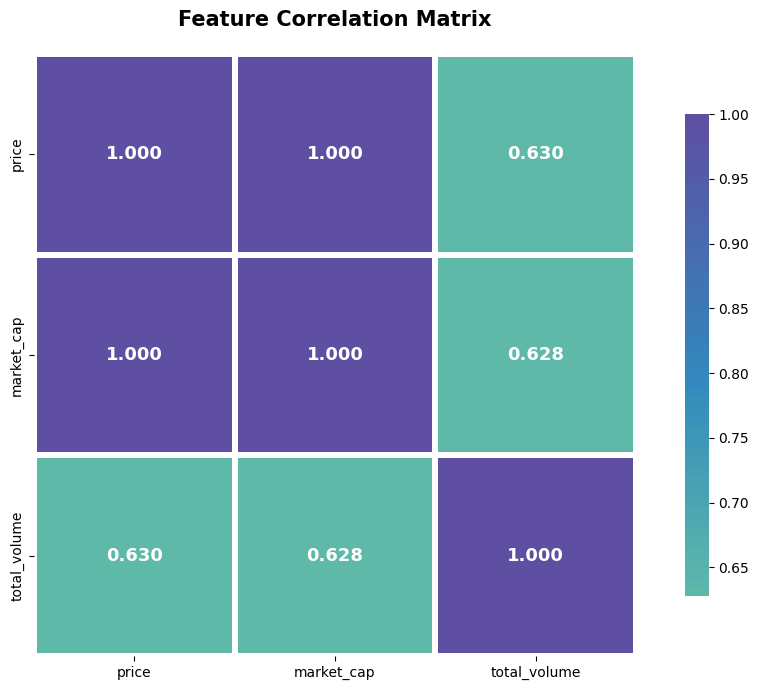

In [11]:
plt.figure(figsize=(10, 7))
corr_matrix = et[['price', 'market_cap', 'total_volume']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='Spectral', center=0, 
            square=True, linewidths=3, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 13, 'weight': 'bold'})
plt.title('Feature Correlation Matrix', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Market Cap Zero Check  
Scanning for rows with zero market cap to spot potential data issues.( **market cap can't be 0 so its a glitch **) 


In [12]:
print(et[et['market_cap']==0])

                                         snapped_at    price  market_cap  \
snapped_ist                                                                
2015-08-07 05:30:00+05:30 2015-08-07 00:00:00+00:00  2.83162         0.0   

                           total_volume        date  hour weekday  month  
snapped_ist                                                               
2015-08-07 05:30:00+05:30       90622.0  2015-08-07     5  Friday      8  


### Trend Features  
Adding MA(moving average) windows, returns, and volatility for stronger pattern recognition.


In [13]:
et['roll7'] = et['price'].rolling(window=7).mean()
et['roll30'] = et['price'].rolling(window=30).mean()
et['Daily_Return'] = et['price'].pct_change() * 100
et['Volatility_30d'] = et['Daily_Return'].rolling(window=30).std()

### Trend, Returns, and Volatility Analysis  
Visualizing ETH’s price action with moving averages, daily return swings, and 30-day volatility to understand momentum and market risk behavior.


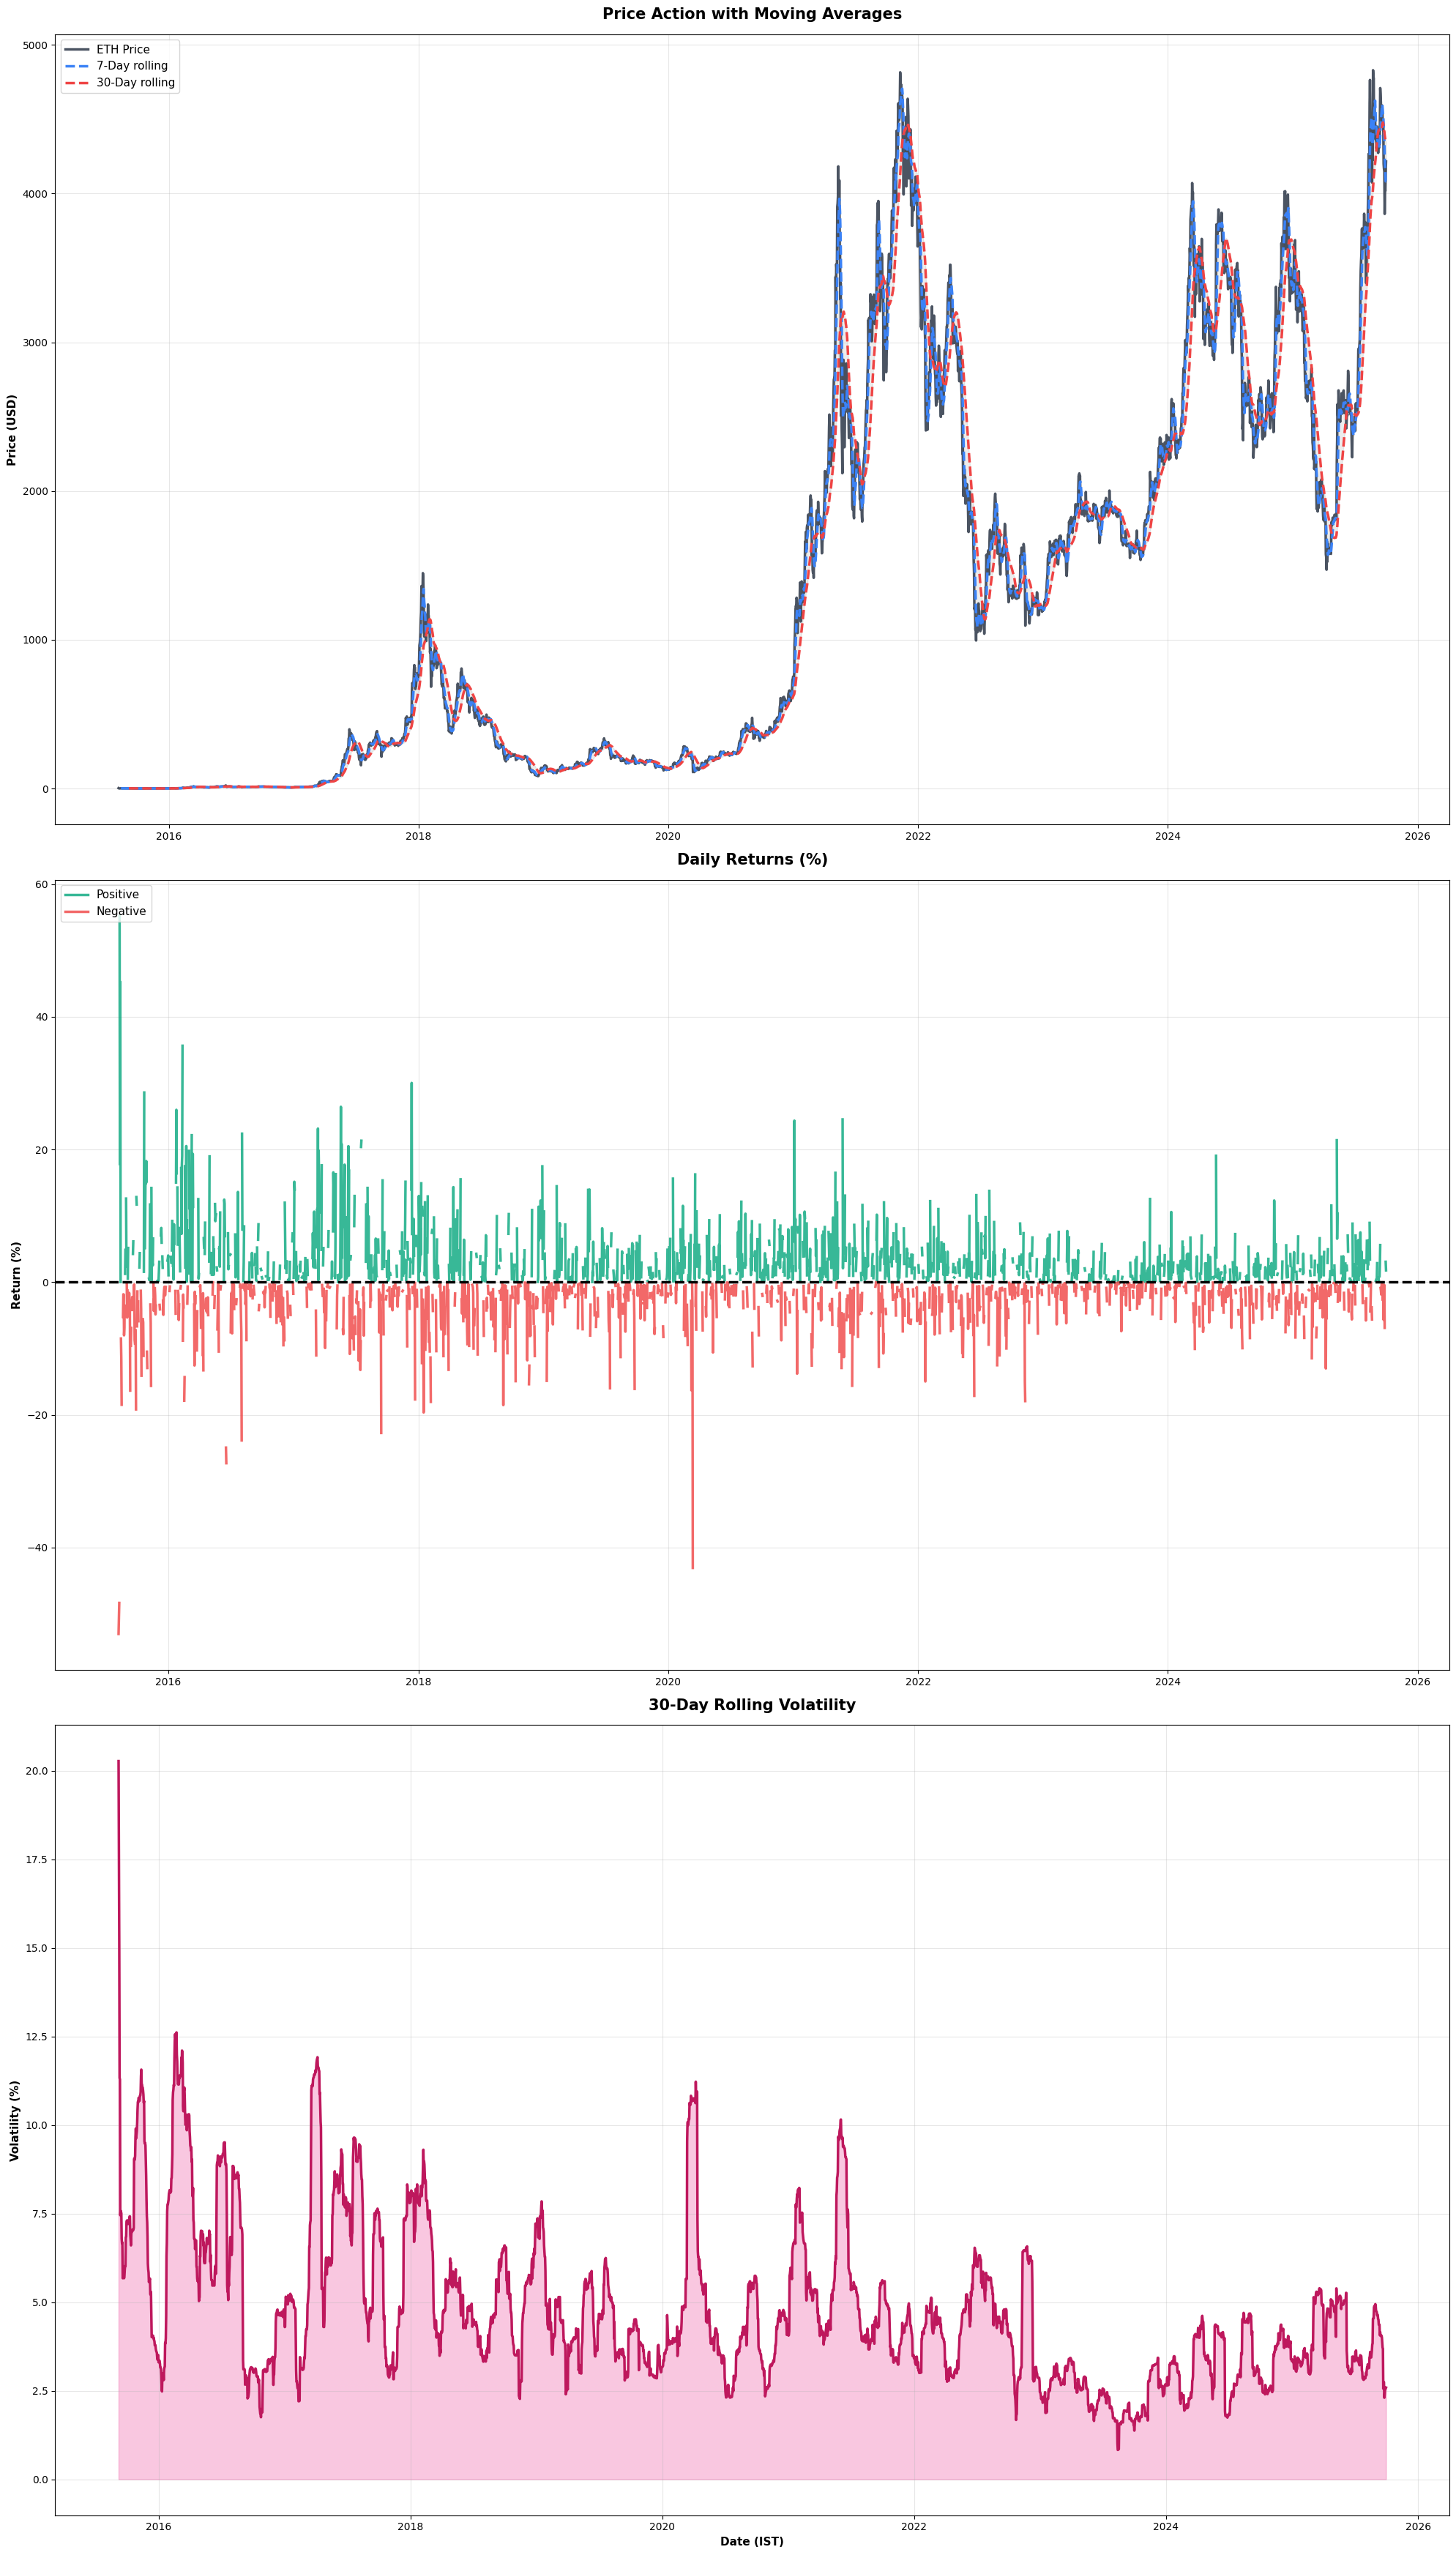

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(20,35))

axes[0].plot(et.index, et['price'], label='ETH Price', linewidth=2.5, alpha=0.8, color='#1e293b')
axes[0].plot(et.index, et['roll7'], label='7-Day rolling', linewidth=2.5, linestyle='--', color='#3b82f6')
axes[0].plot(et.index, et['roll30'], label='30-Day rolling', linewidth=2.5, linestyle='--', color='#ef4444')
axes[0].fill_between(et.index, et['roll7'], et['roll30'], alpha=0.15, color='gray')
axes[0].set_title('Price Action with Moving Averages', fontsize=15, fontweight='bold', pad=15)
axes[0].set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(alpha=0.3)




# Split positive and negative returns
pos = et['Daily_Return'].where(et['Daily_Return'] > 0)
neg = et['Daily_Return'].where(et['Daily_Return'] <= 0)

# Plot positives in green
axes[1].plot(et.index, pos, color='#06a77d', linewidth=2.5, alpha=0.8, label='Positive')

# Plot negatives in red
axes[1].plot(et.index, neg, color='#ef4444', linewidth=2.5, alpha=0.8, label='Negative')

# Baseline at 0
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2.5)

# Titles and labels
axes[1].set_title('Daily Returns (%)', fontsize=15, fontweight='bold', pad=15)
axes[1].set_ylabel('Return (%)', fontsize=11, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(alpha=0.3)


axes[2].plot(et.index, et['Volatility_30d'], linewidth=2.5, color='#be185d')
axes[2].fill_between(et.index, et['Volatility_30d'], alpha=0.3, color='#ec4899')
axes[2].set_title('30-Day Rolling Volatility', fontsize=15, fontweight='bold', pad=15)
axes[2].set_xlabel('Date (IST)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Volatility (%)', fontsize=11, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Hourly Market Insights  
Finding the peak and weakest price hours to understand intraday behavior.


In [15]:
hourly_avg = et.groupby('hour')['price'].mean().sort_values(ascending=False)
print(f"\nBest Trading Hours (IST):")
print(f"  Peak Hour: {hourly_avg.index[0]}:00 - Avg Price: ${hourly_avg.iloc[0]:,.2f}")
print(f"  Low Hour:  {hourly_avg.index[-1]}:00 - Avg Price: ${hourly_avg.iloc[-1]:,.2f}")


Best Trading Hours (IST):
  Peak Hour: 5:00 - Avg Price: $1,281.53
  Low Hour:  5:00 - Avg Price: $1,281.53


### Full Hourly Averages  
Viewing the complete hourly price distribution.


In [16]:
print(hourly_avg)

hour
5    1281.533378
Name: price, dtype: float64


### Hourly Price Statistics  
Displaying descriptive stats for each hour to understand distribution, spread, and volatility across the intraday cycle.


In [17]:
print(et.groupby('hour')['price'].describe())

       count         mean         std       min         25%         50%  \
hour                                                                      
5     3707.0  1281.533378  1298.30524  0.432979  170.367379  665.225786   

             75%          max  
hour                           
5     2265.99909  4829.225542  


### Intraday Cycle: Weekly View  
Calculating day-wise mean prices to uncover weekly momentum shifts.


In [18]:
weekly_avg = et.groupby('weekday')['price'].mean()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg = weekly_avg.reindex(days_order)
print(f"\nWeekly Patterns:")
print(f"  Best Day: {weekly_avg.idxmax()} - Avg: ${weekly_avg.max():,.2f}")
print(f"  Worst Day: {weekly_avg.idxmin()} - Avg: ${weekly_avg.min():,.2f}")


Weekly Patterns:
  Best Day: Tuesday - Avg: $1,285.05
  Worst Day: Wednesday - Avg: $1,277.59


## Price Snapshot
Capturing current, highest, and lowest prices to highlight key market levels.


In [19]:
current_price = et['price'].iloc[-1]
ethighprice = et['price'].max()
etlowprice = et['price'].min()

## Price Metrics
Summarizing current, high, low, average, and range for market overview.


In [20]:
print(' Price Metrics:')
print(f"  Current Price:      ${current_price:,.2f}")
print(f"  All-Time High:      ${ethighprice:,.2f}")
print(f"  All-Time Low:       ${etlowprice:,.2f}")
print(f"  Average Price:      ${et['price'].mean():,.2f}")
print(f"  Price Range:        ${ethighprice - etlowprice:,.2f}")

 Price Metrics:
  Current Price:      $4,215.61
  All-Time High:      $4,829.23
  All-Time Low:       $0.43
  Average Price:      $1,281.53
  Price Range:        $4,828.79


## Performance Overview
Summarizing total return, average daily return, best/worst days, and overall win rate for market performance insights.


In [21]:
print( 'Performance:')
total_return = ((current_price - et['price'].iloc[0]) / et['price'].iloc[0]) * 100
print(f"  Total Return:       {total_return:+.2f}%")
print(f"  Avg Daily Return:   {et['Daily_Return'].mean():.3f}%")
print(f"  Best Day:           {et['Daily_Return'].max():.2f}%")
print(f"  Worst Day:          {et['Daily_Return'].min():.2f}%")





positive_days = (et['Daily_Return'] > 0).sum()
total_days = et['Daily_Return'].notna().sum()
win_rate = (positive_days / total_days) * 100
print(f"  Win Rate:           {win_rate:.1f}% ({positive_days}/{total_days} periods)")

Performance:
  Total Return:       +148776.36%
  Avg Daily Return:   0.350%
  Best Day:           55.24%
  Worst Day:          -53.00%
  Win Rate:           51.0% (1891/3706 periods)


## Risk Metrics
Displaying daily and current volatility along with maximum drawdown to assess market risk.


In [22]:
print('Risk Metrics:')
print(f"  Daily Volatility:   {et['Daily_Return'].std():.2f}%")
print(f"  Current Volatility: {et['Volatility_30d'].iloc[-1]:.2f}%")
print(f"  Max Drawdown:       {((et['price'].min() - et['price'].max()) / et['price'].max() * 100):.2f}%")

Risk Metrics:
  Daily Volatility:   5.50%
  Current Volatility: 2.59%
  Max Drawdown:       -99.99%


## Market Cap & Volume
Summarizing current and average market capitalization along with daily trading volume for market insights.


In [23]:
print('Market Cap & Volume:')
print(f"  Current Market Cap: ${et['market_cap'].iloc[-1]:,.0f}")
print(f"  Avg Market Cap:     ${et['market_cap'].mean():,.0f}")
print(f"  Avg Daily Volume:   ${et['total_volume'].mean():,.0f}")
print(f"  Latest Volume:      ${et['total_volume'].iloc[-1]:,.0f}")

Market Cap & Volume:
  Current Market Cap: $508,909,498,092
  Avg Market Cap:     $151,220,018,994
  Avg Daily Volume:   $11,687,405,676
  Latest Volume:      $34,604,598,515


## Advanced Analytics
Analyzing price dynamics, flagging extreme returns/volumes, and exploring price-volume lead/lag relationships.


ADF log_price: stat=-2.550, p=0.1037
ADF log_return: stat=-11.555, p=0.0000


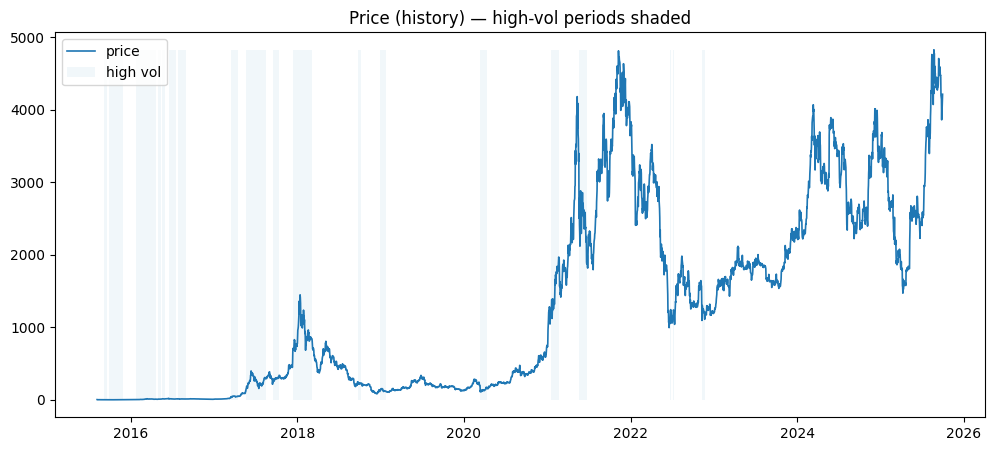

Anomalies: return_z>3 = 57 , volume_z>3 = 26


,price,total_volume,adv_log_return,adv_ret_z,adv_vol_z
snapped_ist,,,,,
2015-08-11 05:30:00+05:30,1.067379,1.518998e+06,0.439775,7.866057,-2.429486
2015-08-13 05:30:00+05:30,1.825395,4.380143e+06,0.373377,6.673074,-2.079442
2017-03-19 05:30:00+05:30,44.088797,1.518895e+08,0.312130,5.572657,-0.907347
2016-02-11 05:30:00+05:30,6.005000,2.875297e+07,0.304773,5.440468,-1.457491
2017-12-12 05:30:00+05:30,661.841332,3.691984e+09,0.262576,4.682315,0.147307
2015-10-22 05:30:00+05:30,0.565462,9.793041e+05,0.251393,4.481382,-2.574578
2017-05-19 05:30:00+05:30,122.162783,3.807534e+08,0.234508,4.178017,-0.603588
2016-01-24 05:30:00+05:30,2.131691,9.578401e+06,0.230912,4.113407,-1.820823


Price-volume peak cross-corr at lag -2: 0.631  (positive => volume leads price)


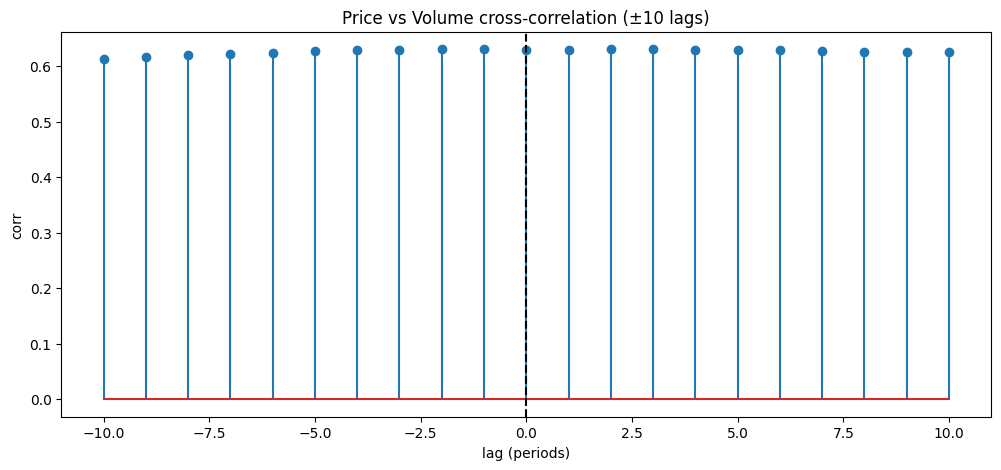

,adf_log_price_p,adf_log_return_p,vol_30_median,anomaly_ret_count,anomaly_vol_count,price_vol_best_lag,price_vol_best_corr
0,0.103741,3.383993e-21,0.042626,57,26,-2,0.630863


In [24]:


from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (12,5)

# 1) Log price & log returns (non-destructive)
et['adv_log_price'] = np.log(et['price'])
et['adv_log_return'] = et['adv_log_price'].diff()          # raw log-return
et['adv_log_return_pct'] = et['adv_log_return'] * 100      # percent-like

# 2) Quick ADF stationarity check (print concise result)
def simple_adf(s, name):
    s = s.dropna()
    if len(s) < 10:
        print(f"ADF {name}: not enough data ({len(s)} samples)")
        return {'stat': np.nan, 'p': np.nan}
    r = adfuller(s, autolag='AIC')
    print(f"ADF {name}: stat={r[0]:.3f}, p={r[1]:.4f}")
    return {'stat': r[0], 'p': r[1]}

adf_lp = simple_adf(et['adv_log_price'], 'log_price')
adf_lr = simple_adf(et['adv_log_return'].dropna(), 'log_return')

# 3) Rolling volatility (30-period) and regime tagging (simple threshold)
et['adv_roll_vol_30'] = et['adv_log_return'].rolling(window=30).std()
vol_med = et['adv_roll_vol_30'].median(skipna=True)
et['adv_vol_regime'] = np.where(et['adv_roll_vol_30'] > vol_med * 1.5, 'high', 'low')

# plot price with high-vol shading
plt.plot(et.index, et['price'], label='price', linewidth=1.2)
mask = et['adv_vol_regime'] == 'high'
plt.fill_between(et.index, et['price'].min(), et['price'].max(), where=mask, alpha=0.06, label='high vol')
plt.title('Price (history) — high-vol periods shaded')
plt.legend()
plt.show()

# 4) Simple anomaly flags (z-score on returns and log(volume))
et['adv_ret_z'] = zscore(et['adv_log_return'].fillna(0))
et['adv_vol_z'] = zscore(np.log1p(et['total_volume'].fillna(0)))
et['adv_ret_anom'] = et['adv_ret_z'].abs() > 3
et['adv_vol_anom'] = et['adv_vol_z'].abs() > 3

print("Anomalies: return_z>3 =", et['adv_ret_anom'].sum(),
      ", volume_z>3 =", et['adv_vol_anom'].sum())

# show top anomaly rows (concise)
anom_rows = et[et['adv_ret_anom'] | et['adv_vol_anom']].sort_values('adv_log_return', ascending=False)
if not anom_rows.empty:
    display(anom_rows[['price','total_volume','adv_log_return','adv_ret_z','adv_vol_z']].head(8))
else:
    print("No extreme anomalies found by z>3 rule.")

# 5) Price-volume lead/lag check (quick scan +/- 10 lags)
def crosscorr(x, y, lag):
    return x.corr(y.shift(lag))
lags = range(-10, 11)
cc = {lag: crosscorr(et['price'], et['total_volume'], lag) for lag in lags}
best_lag = max(cc, key=lambda k: abs(cc[k]) if pd.notna(cc[k]) else -1)
print(f"Price-volume peak cross-corr at lag {best_lag}: {cc[best_lag]:.3f}  (positive => volume leads price)")

# stem plot for quick visual
plt.stem(list(cc.keys()), [cc[l] for l in cc], use_line_collection=True)
plt.axvline(0, color='k', linestyle='--')
plt.title('Price vs Volume cross-correlation (±10 lags)')
plt.xlabel('lag (periods)')
plt.ylabel('corr')
plt.show()


# 7) Diagnostics summary (compact table)
diag = {
    'adf_log_price_p': adf_lp['p'],
    'adf_log_return_p': adf_lr['p'],
    'vol_30_median': vol_med,
    'anomaly_ret_count': int(et['adv_ret_anom'].sum()),
    'anomaly_vol_count': int(et['adv_vol_anom'].sum()),
    'price_vol_best_lag': int(best_lag),
    'price_vol_best_corr': float(cc[best_lag]) if pd.notna(cc[best_lag]) else np.nan
}
diag_df = pd.DataFrame([diag])
display(diag_df)



## Price Forecasting
Using LightGBM and XGBoost to model past price/volume data and project future price trends.


Train=3643, Test=60, Features=4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 3643, number of used features: 4
[LightGBM] [Info] Start training from score 1233.263954

=== MODEL PERFORMANCE (1-step ahead) ===
LightGBM:  MAE=179.2827, RMSE=236.5339
XGBoost :  MAE=197.9234, RMSE=251.3509


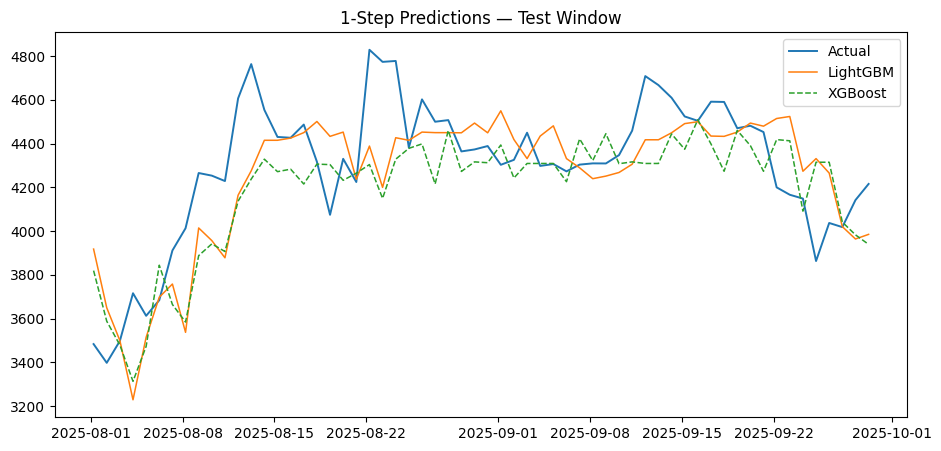

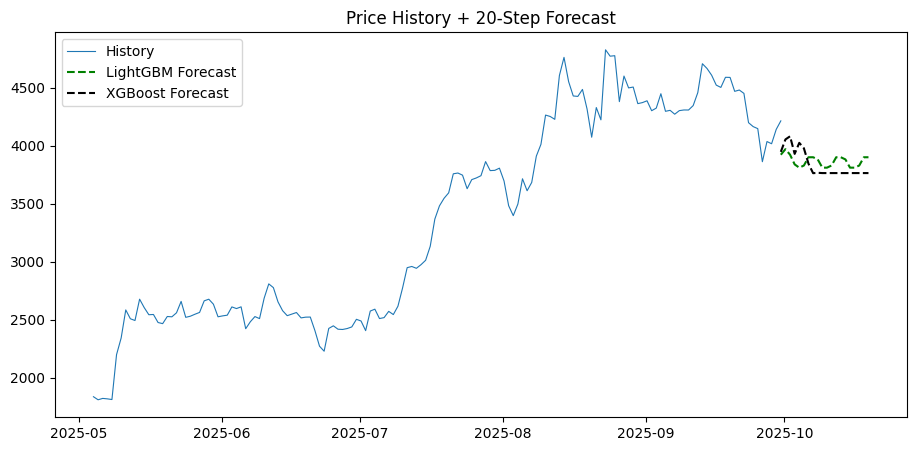

,LightGBM_forecast,XGBoost_forecast
2025-09-30 05:30:00+05:30,3923.204859,3948.250000
2025-10-01 05:30:00+05:30,3971.451570,4055.270264
2025-10-02 05:30:00+05:30,3923.476264,4082.427490
2025-10-03 05:30:00+05:30,3839.969774,3930.631104
2025-10-04 05:30:00+05:30,3811.538484,4025.902832
2025-10-05 05:30:00+05:30,3830.304274,3979.087158
2025-10-06 05:30:00+05:30,3901.452184,3845.396729
2025-10-07 05:30:00+05:30,3901.700618,3764.029053
2025-10-08 05:30:00+05:30,3882.934828,3767.194824
2025-10-09 05:30:00+05:30,3811.786918,3764.959473


In [25]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams['figure.figsize'] = (11,5)

# Dependency check
try:
    import lightgbm as lgb
    import xgboost as xgb
except Exception as e:
    raise ImportError("Install lightgbm & xgboost first. Error: " + str(e))

# ---------------------
# CONFIG
# ---------------------
n_lags = 3
forecast_horizon = 20
test_days = 60

# ---------------------
# FEATURE ENGINEERING
# ---------------------
df = et[['price','total_volume']].copy()

# price lags
for lag in range(1, n_lags+1):
    df[f'adv_simple_price_lag{lag}'] = df['price'].shift(lag)

# volume lag
df['adv_simple_vol_lag1'] = df['total_volume'].shift(1)

# target: next day's price
df['adv_simple_target'] = df['price'].shift(-1)

df = df.dropna()

# ---------------------
# TRAIN–TEST SPLIT
# ---------------------
if len(df) > test_days:
    test = df.iloc[-test_days:].copy()
    train = df.iloc[:-test_days].copy()
else:
    split = int(len(df)*0.8)
    train = df.iloc[:split]
    test = df.iloc[split:]

features = [c for c in df.columns if c.startswith('adv_simple_') and 'target' not in c]

X_train, y_train = train[features], train['adv_simple_target']
X_test, y_test = test[features], test['adv_simple_target']

print(f"Train={len(train)}, Test={len(test)}, Features={len(features)}")

# ---------------------
# MODELS
# ---------------------
lgbm = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)

xgbm = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

# LightGBM — NO EARLY STOPPING (universal compatibility)
lgbm.fit(X_train, y_train)

# XGBoost — early stopping safely supported
xgbm.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)],
         early_stopping_rounds=50,
         verbose=False)


# METRICS

def metrics(label, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label}:  MAE={mae:.4f}, RMSE={rmse:.4f}")

lgb_pred = lgbm.predict(X_test)
xgb_pred = xgbm.predict(X_test)

print("\n=== MODEL PERFORMANCE (1-step ahead) ===")
metrics("LightGBM", y_test, lgb_pred)
metrics("XGBoost ", y_test, xgb_pred)


# TEST PLOT

plt.plot(test.index, y_test, label='Actual', linewidth=1.4)
plt.plot(test.index, lgb_pred, label='LightGBM', linewidth=1.1)
plt.plot(test.index, xgb_pred, label='XGBoost', linestyle='--', linewidth=1.1)
plt.title("1-Step Predictions — Test Window")
plt.legend()
plt.show()


# ITERATIVE FORECAST (20steps)

last_prices = list(df['price'].iloc[-n_lags:])
last_vol = df['total_volume'].iloc[-1]
future_idx = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1),
                           periods=forecast_horizon, freq='D')

def iterative(model):
    p_window = last_prices.copy()
    preds = []
    for i in range(forecast_horizon):
        feat = {}
        for lag in range(1, n_lags+1):
            feat[f'adv_simple_price_lag{lag}'] = p_window[-lag]
        feat['adv_simple_vol_lag1'] = last_vol
        
        feat_df = pd.DataFrame([feat], index=[future_idx[i]])
        feat_df = feat_df[features]
        
        p = model.predict(feat_df)[0]
        preds.append(p)
        p_window.append(p)
    return pd.Series(preds, index=future_idx)

lgb_fc = iterative(lgbm)
xgb_fc = iterative(xgbm)


# FORECAST PLOT

plt.plot(et['price'].iloc[-150:], label='History', linewidth=0.8)
plt.plot(lgb_fc.index, lgb_fc.values, linestyle='--', label='LightGBM Forecast', color='green')
plt.plot(xgb_fc.index, xgb_fc.values, linestyle='--', label='XGBoost Forecast', color='black')
plt.title("Price History + 20-Step Forecast")
plt.legend()
plt.show()


# FORECAST TABLE

fc_df = pd.DataFrame({
    'LightGBM_forecast': lgb_fc.values,
    'XGBoost_forecast': xgb_fc.values
}, index=future_idx)

display(fc_df)


